# 🧩 01 - Collecte Multi-Sources (Kaggle + AniList + Interactions)

## Objectifs
- Fusionner plusieurs sources hétérogènes : Kaggle, AniList API, et fichiers utilisateurs
- Construire une base d’apprentissage riche (contenu + interactions)
- Préparer la suite : analyse exploratoire, modélisation collaborative et fine-tuning



In [4]:
import pandas as pd
import requests, time, json
from pathlib import Path

Path("../data/api/").mkdir(parents=True, exist_ok=True)
Path("../data/processed/").mkdir(parents=True, exist_ok=True)

# Données Kaggle
details = pd.read_csv("../../data/raw/details.csv")
stats = pd.read_csv("../../data/raw/stats.csv")

details = details[[
    "mal_id", "title", "genres", "themes", "demographics", "type",
    "rating", "score", "members", "year", "popularity", "synopsis"
]]
stats = stats[[
    "mal_id", "watching", "completed", "on_hold", "dropped", "plan_to_watch", "total"
]]

# Fusion initiale
anime_df = pd.merge(details, stats, on="mal_id", how="left")
print(f"✅ Anime dataset : {anime_df.shape}")


✅ Anime dataset : (28955, 18)


In [6]:
# Chargement des profils et favoris
profiles = pd.read_csv("../../data/raw/profiles.csv")
favs = pd.read_csv("../../data/raw/favs.csv")
recs = pd.read_csv("../../data/raw/recommendations.csv")

print(f"Profiles : {profiles.shape} | Favs : {favs.shape} | Recs : {recs.shape}")


Profiles : (337155, 10) | Favs : (4178747, 3) | Recs : (105249, 2)


In [7]:
# Nettoyage basique
profiles = profiles.drop_duplicates(subset="username")
profiles['gender'] = profiles['gender'].fillna("Unknown")
profiles['location'] = profiles['location'].fillna("Unknown")

# Filtrage des favoris liés aux animes
favs = favs[favs['fav_type'] == 'anime']
favs = favs.dropna(subset=['id'])
favs['id'] = favs['id'].astype(int)
favs.rename(columns={'id': 'mal_id'}, inplace=True)

# Nombre de favoris par anime
fav_counts = favs['mal_id'].value_counts().reset_index()
fav_counts.columns = ['mal_id', 'fav_count']

# Fusion dans le dataset principal
anime_df = anime_df.merge(fav_counts, on='mal_id', how='left')
anime_df['fav_count'] = anime_df['fav_count'].fillna(0)
print(f"✅ Fusion favoris : {anime_df.shape}")


✅ Fusion favoris : (28955, 19)


In [8]:
# Recommandations croisées
recs_grouped = recs.groupby('mal_id')['recommendation_mal_id'].apply(list).reset_index()
anime_df = anime_df.merge(recs_grouped, on='mal_id', how='left')

anime_df['nb_recommendations'] = anime_df['recommendation_mal_id'].apply(
    lambda x: len(x) if isinstance(x, list) else 0
)
print(f"✅ Fusion recommandations : {anime_df.shape}")


✅ Fusion recommandations : (28955, 21)


In [9]:
query = '''
query ($page: Int) {
  Page(page: $page, perPage: 50) {
    media(type: ANIME, sort: POPULARITY_DESC) {
      id
      title { romaji english }
      averageScore
      popularity
      episodes
      seasonYear
      format
      description
      genres
      studios(isMain: true) { nodes { name } }
      coverImage { large }
    }
  }
}
'''

def fetch_anilist_data(pages=10):
    all_data = []
    for page in range(1, pages + 1):
        response = requests.post(
            'https://graphql.anilist.co',
            json={'query': query, 'variables': {'page': page}},
            timeout=30
        )
        try:
            data = response.json()['data']['Page']['media']
            all_data.extend(data)
            print(f"Page {page} récupérée ({len(data)} animes)")
            time.sleep(1)
        except Exception as e:
            print("Erreur:", e)
            break
    return all_data

anilist_data = fetch_anilist_data(pages=10)
anilist_df = pd.json_normalize(anilist_data)

anilist_df.rename(columns={
    "title.romaji": "title_romaji",
    "title.english": "title_english",
    "averageScore": "api_score",
    "popularity": "api_popularity",
    "seasonYear": "year",
    "format": "type",
    "coverImage.large": "image_url",
    "studios.nodes": "studios"
}, inplace=True)

anilist_df["title"] = anilist_df["title_english"].fillna(anilist_df["title_romaji"])
anilist_df["studios"] = anilist_df["studios"].apply(lambda x: x[0]["name"] if isinstance(x, list) and len(x) > 0 else None)

anime_df = pd.merge(
    anime_df,
    anilist_df[["title", "api_score", "api_popularity", "image_url", "studios"]],
    on="title", how="left"
)

print(f"✅ Dataset enrichi : {anime_df.shape}")


Page 1 récupérée (50 animes)
Page 2 récupérée (50 animes)
Page 3 récupérée (50 animes)
Page 4 récupérée (50 animes)
Page 5 récupérée (50 animes)
Page 6 récupérée (50 animes)
Page 7 récupérée (50 animes)
Page 8 récupérée (50 animes)
Page 9 récupérée (50 animes)
Page 10 récupérée (50 animes)
✅ Dataset enrichi : (28955, 25)


In [11]:
anime_df.to_csv("../../data/processed/anime_master.csv", index=False)
profiles.to_csv("../../data/processed/user_profiles.csv", index=False)

print("💾 Sauvegarde terminée : anime_master.csv + user_profiles.csv")


💾 Sauvegarde terminée : anime_master.csv + user_profiles.csv


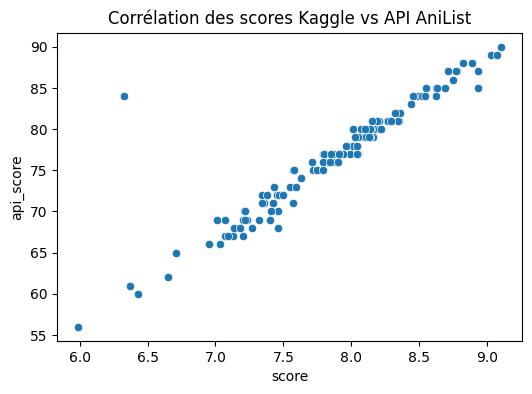

Corrélation Score Kaggle/API : 0.9343185551819206
Distribution des favoris : count    28955.000000
mean        52.729788
std        575.642014
min          0.000000
25%          0.000000
50%          0.000000
75%          2.000000
max      31558.000000
Name: fav_count, dtype: float64


In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.scatterplot(x='score', y='api_score', data=anime_df)
plt.title("Corrélation des scores Kaggle vs API AniList")
plt.savefig('../../reports/figures/api_vs_kaggle_correlation.png', dpi=300, bbox_inches='tight')
plt.show()

print("Corrélation Score Kaggle/API :", anime_df[['score', 'api_score']].corr().iloc[0,1])
print("Distribution des favoris :", anime_df['fav_count'].describe())


## Synthèse :
- Base Kaggle enrichie avec **interactions utilisateurs (favoris + recommandations)**  
- Données externes issues de **l’API AniList**
- Intégration des **profils utilisateurs** (genre, localisation, activité)

### 🚀 Étapes suivantes :
- `02_data_cleaning.ipynb` : harmoniser, gérer les valeurs manquantes
- `03_data_exploration.ipynb` : explorer les patterns utilisateur/anime
- `04_feature_engineering.ipynb` : créer les embeddings & features mixtes
